In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"historical_data.csv", parse_dates=["created_at", "actual_delivery_time"]).drop("store_id", axis=1)
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## Data Preparations

In [3]:
# target column in minutes
df["delivery_duration_min"] = round((df["actual_delivery_time"] - df["created_at"]).dt.seconds / 60, 2)

### Feature engineering: date columns

In [4]:
df["month"] = df["created_at"].dt.month_name()
df["day"] = df["created_at"].dt.day_name()
df["is_weekend"] = np.where(df["day"].isin(["Saturday", "Sunday"]), 1, 0)
df["hour"] = df["created_at"].dt.hour

conditions = [
    (df["hour"] >= 5) & (df["hour"] < 12),
    (df["hour"] >= 12) & (df["hour"] < 17),
    (df["hour"] >= 17) & (df["hour"] < 21),
    (df["hour"] >= 21) | (df["hour"] < 5)
]

choices = ["Morning", "Afternoon", "Evening", "Night"]
df["time_of_day"] = np.select(conditions, choices)

### Fill in necessary columns and drop nulls

In [5]:
df["store_primary_category"] = df["store_primary_category"].fillna("none")

print((df.isnull().sum() / len(df) * 100).round(2))
df.dropna(inplace=True)

market_id                                       0.50
created_at                                      0.00
actual_delivery_time                            0.00
store_primary_category                          0.00
order_protocol                                  0.50
total_items                                     0.00
subtotal                                        0.00
num_distinct_items                              0.00
min_item_price                                  0.00
max_item_price                                  0.00
total_onshift_dashers                           8.24
total_busy_dashers                              8.24
total_outstanding_orders                        8.24
estimated_order_place_duration                  0.00
estimated_store_to_consumer_driving_duration    0.27
delivery_duration_min                           0.00
month                                           0.00
day                                             0.00
is_weekend                                    

### Handle outliers and filter data

Based on the description for this dataset:
1. *total_onshift_dashers:* Number of available dashers who are within 10 miles of the store at the time of order creation
2. *total_busy_dashers:* Subset of above total_onshift_dashers who are currently working on an order

**It's impossible to have "total_onshift_dashers" less than "total_busy_dashers"**

In [6]:
# convert negative values
columns = ["min_item_price", "max_item_price", "total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]
for col in columns: df[col] = df[col].abs()

# convert numeric columns to categorical
for col in ["market_id", "order_protocol"]:
    df[col] = df[col].astype(int).astype(str)
    
df = df.query("total_onshift_dashers >= total_busy_dashers")

### Feature engineering for the rest of the columns

In [7]:
df["subtotal"] = df["subtotal"] / 100
df["avg_item_price"] = round(df["subtotal"] / df["total_items"], 2)
df["min_item_price"] = df["min_item_price"] / 100
df["max_item_price"] = df["max_item_price"] / 100

df["available_couriers_10_miles"] = df["total_onshift_dashers"] - df["total_busy_dashers"]

df["previous_prediction"] = round((df["estimated_order_place_duration"] + df["estimated_store_to_consumer_driving_duration"]) / 60, 2)
df["diff_actual_vs_predicted"] = round(df["delivery_duration_min"] - df["previous_prediction"], 2)

### Removing too large values

In [8]:
df_info = df.iloc[:, 5:].describe()
df_info

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_min,is_weekend,hour,avg_item_price,available_couriers_10_miles,previous_prediction,diff_actual_vs_predicted
count,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000,139281.000000
mean,3.229112,27.122523,2.693806,6.817653,11.593805,45.976967,39.738888,57.995233,309.565691,545.735168,47.314753,0.332019,8.369907,9.721835,6.238080,14.255012,33.059742
std,2.738413,18.454855,1.638925,5.189205,5.621039,36.082407,31.683956,54.327603,90.765520,218.997450,19.391161,0.470940,8.687149,5.140661,9.433395,3.914531,18.830558
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.950000,0.000000,0.000000,0.000000,0.000000,2.550000,-10.450000
25%,2.000000,14.130000,2.000000,2.990000,7.990000,17.000000,13.000000,15.000000,251.000000,383.000000,34.950000,0.000000,2.000000,6.470000,0.000000,11.400000,21.060000
50%,3.000000,22.370000,2.000000,5.950000,10.950000,37.000000,32.000000,39.000000,251.000000,543.000000,44.080000,0.000000,3.000000,8.950000,3.000000,14.180000,29.730000
75%,4.000000,34.450000,3.000000,9.250000,13.950000,68.000000,60.000000,87.000000,446.000000,702.000000,55.850000,1.000000,19.000000,11.940000,8.000000,16.970000,41.090000
max,411.000000,225.000000,20.000000,147.000000,147.000000,171.000000,148.000000,285.000000,2715.000000,1711.000000,1221.370000,1.000000,23.000000,147.000000,86.000000,53.700000,1204.400000


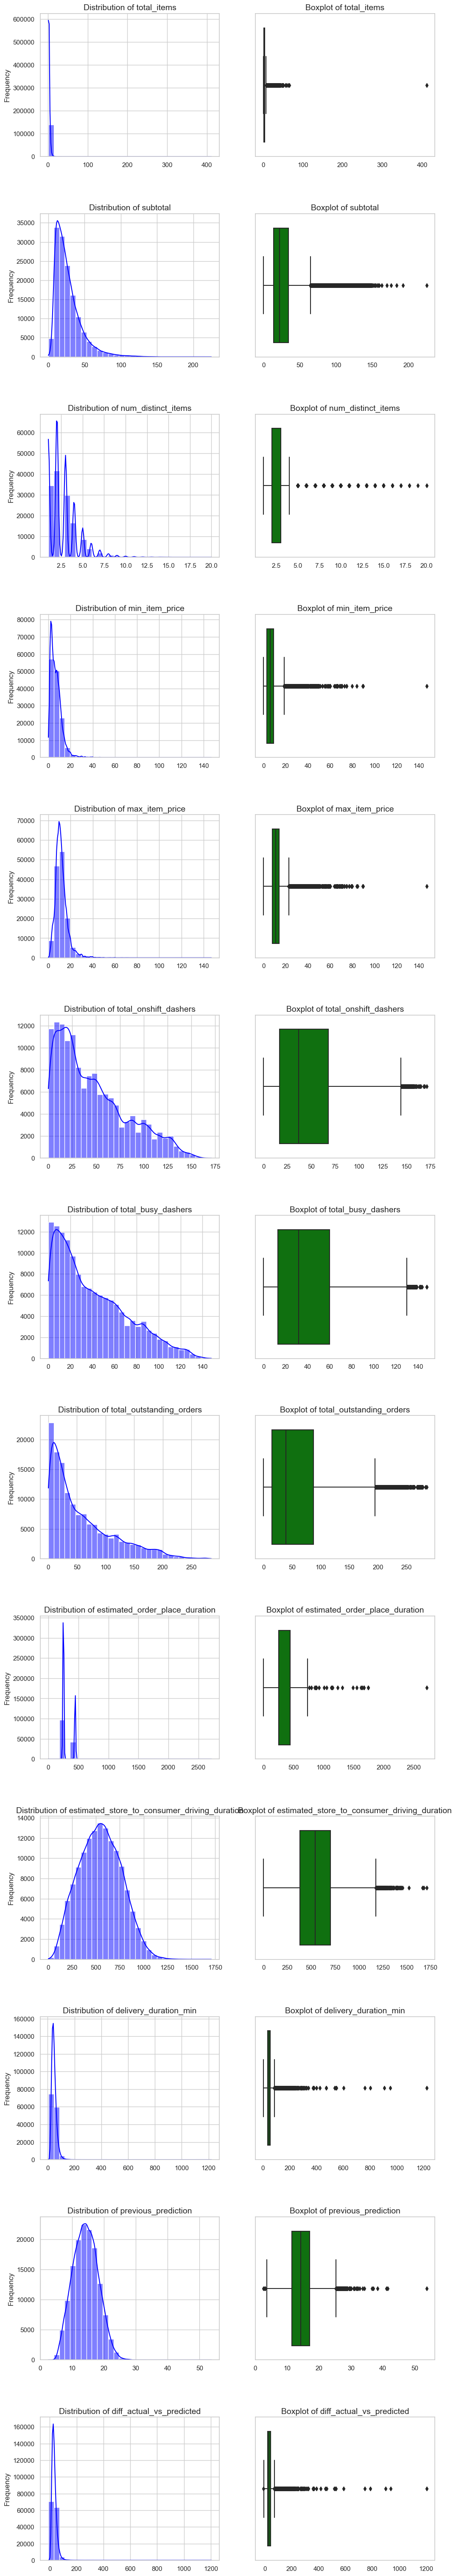

In [9]:
# creating distribution plot and boxplot to identify outliers for specified columns
columns = ["total_items", "subtotal", "num_distinct_items", "min_item_price", "max_item_price", "total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders", "estimated_order_place_duration", "estimated_store_to_consumer_driving_duration", "delivery_duration_min", "previous_prediction", "diff_actual_vs_predicted"]

sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=len(columns), figsize=(12, 6 * len(columns)))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

for i, col in enumerate(columns):
    sns.histplot(df[col], bins=30, ax=axs[i, 0], color="blue", kde=True)
    axs[i, 0].set_title(f"Distribution of {col}", fontsize=14)
    axs[i, 0].set_xlabel("")
    axs[i, 0].set_ylabel("Frequency")

    sns.boxplot(x=df[col], ax=axs[i, 1], color="green")
    axs[i, 1].set_title(f"Boxplot of {col}", fontsize=14)
    axs[i, 1].set_xlabel("")
    axs[i, 1].grid(False)

plt.show()

In [10]:
# filter data to get rid of outliers
df = df.loc[
    (df["total_items"] < 100) & (df["subtotal"] < 25000) &
    (df["min_item_price"] < 100) & (df["max_item_price"] < 100) &
    (df["estimated_order_place_duration"] < 2000) &
    (df["estimated_store_to_consumer_driving_duration"] < 2000) &
    (df["delivery_duration_min"] > 5) & (df["delivery_duration_min"] < 650) &
    (df["previous_prediction"] < 40) & (df["diff_actual_vs_predicted"] < 120)
]

df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,delivery_duration_min,month,day,is_weekend,hour,time_of_day,avg_item_price,available_couriers_10_miles,previous_prediction,diff_actual_vs_predicted
0,1,2015-02-06 22:24:17,2015-02-06 23:27:16,american,1,4,34.41,4,5.57,12.39,...,62.98,February,Friday,0,22,Night,8.60,19.0,21.78,41.20
2,3,2015-01-22 20:39:28,2015-01-22 21:09:09,none,1,1,19.00,1,19.00,19.00,...,29.68,January,Thursday,0,20,Evening,19.00,1.0,18.93,10.75
3,3,2015-02-03 21:21:45,2015-02-03 22:13:00,none,1,6,69.00,5,6.00,18.00,...,51.25,February,Tuesday,0,21,Night,11.50,0.0,12.25,39.00
4,3,2015-02-15 02:40:36,2015-02-15 03:20:26,none,1,3,39.00,3,11.00,16.00,...,39.83,February,Sunday,1,2,Night,13.00,0.0,18.27,21.56
5,3,2015-01-28 20:30:38,2015-01-28 21:08:58,none,1,3,50.00,3,15.00,19.00,...,38.33,January,Wednesday,0,20,Evening,16.67,0.0,13.07,25.26


### Prepare data for modelling

In [11]:
# select necessary columns
columns_to_remove = ["created_at", "actual_delivery_time", "total_onshift_dashers", "total_busy_dashers", "estimated_order_place_duration", "estimated_store_to_consumer_driving_duration", "previous_prediction"]
filtered_df = df.drop(columns=columns_to_remove)

# create dummy variables
categorical_columns = filtered_df.select_dtypes(include="O").columns
filtered_df = pd.get_dummies(filtered_df, columns=categorical_columns, drop_first=True, dtype=int)

filtered_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,delivery_duration_min,is_weekend,hour,avg_item_price,...,month_January,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,4,34.41,4,5.57,12.39,21.0,62.98,0,22,8.60,...,0,0,0,0,0,0,0,0,0,1
2,1,19.00,1,19.00,19.00,0.0,29.68,0,20,19.00,...,1,0,0,0,1,0,0,1,0,0
3,6,69.00,5,6.00,18.00,2.0,51.25,0,21,11.50,...,0,0,0,0,0,1,0,0,0,1
4,3,39.00,3,11.00,16.00,9.0,39.83,1,2,13.00,...,0,0,0,1,0,0,0,0,0,1
5,3,50.00,3,15.00,19.00,2.0,38.33,0,20,16.67,...,1,0,0,0,0,0,1,1,0,0


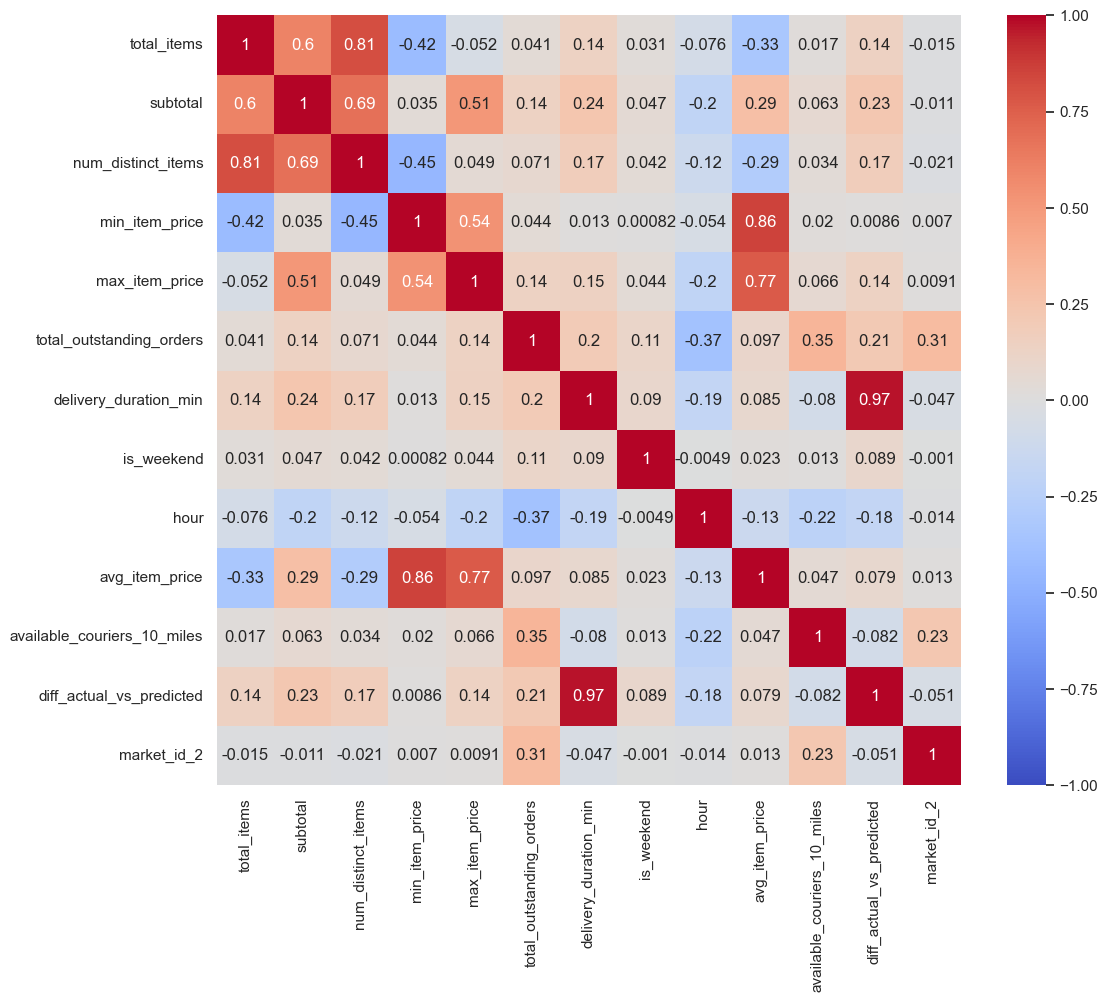

In [12]:
# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_df.iloc[:, :13].corr(numeric_only=True), vmin=-1, vmax=1, cmap="coolwarm", annot=True);
plt.show()

### Export data for modelling

In [13]:
filtered_df.to_csv("prepared_dataset", index=False)